In [5]:
import pandas as pd
import numpy as np
import ccxt
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint
from statsmodels.regression.rolling import RollingOLS
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm


futures_pairs =  [
    "BTCUSDT", "ETHUSDT", "LINKUSDT", "BNBUSDT", "TRXUSDT", "DOTUSDT", "ADAUSDT", "EOSUSDT", "LTCUSDT",
    "BCHUSDT", "XRPUSDT", "ETCUSDT", "FILUSDT", "EGLDUSDT", "DOGEUSDT", "UNIUSDT", "THETAUSDT", "XLMUSDT",
    "SOLUSDT", "FTMUSDT", "SANDUSDT", "MANAUSDT", "AVAXUSDT", "GALAUSDT", "MATICUSDT", "NEARUSDT",
    "ATOMUSDT", "AAVEUSDT", "AXSUSDT", "ROSEUSDT", "XTZUSDT", "ICXUSDT", "ALGOUSDT", "RUNEUSDT",
    "APEUSDT", "VETUSDT", "ZILUSDT", "KNCUSDT", "XMRUSDT", "GMTUSDT", "OPUSDT", "ENSUSDT", "CHZUSDT", "APTUSDT"
]

In [6]:
def fetch_prices(binance, symbol, look_back_days): 
    # Prepare empty dataframe for results
    df_final = pd.DataFrame()
    
    # Calculate the end timestamp for the data fetching
    end_timestamp = binance.milliseconds()
    since_timestamp = end_timestamp - look_back_days * 24 * 60 * 60 * 1000 
    
    while since_timestamp < end_timestamp:
        try:
            # Fetch OHLCV data
            price_data = binance.fetch_ohlcv(symbol, '1h', since=since_timestamp, limit=1000)
            df = pd.DataFrame(price_data, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])

            # Concatenate with the final dataframe
            df_final = pd.concat([df_final, df])
            
            # Update the since_timestamp to the last timestamp fetched
            since_timestamp = df_final['timestamp'].max() + (60 * 60 * 1000)  # Add one hour

        except Exception as e:
            print(f"Error in fetching prices: {e}")
            break
    
    # Remove duplicates and sort the dataframe
    df_final.drop_duplicates(subset='timestamp', keep='first', inplace=True)
    df_final.sort_values(by='timestamp', inplace=True)
    
    return df_final

binance = ccxt.binance()


# Initialize an empty DataFrame for combined prices
combined_prices_df = pd.DataFrame()

# Iterate over each ETF in your universe
for symbol in futures_pairs:
    
    # Fetch the data
    prices = fetch_prices(binance, symbol, 120)
    
    # Add this ETF's adjusted close prices to the combined DataFrame
    combined_prices_df[symbol] = prices['close']


combined_prices_df.to_csv("futures_prices.csv", index=True)

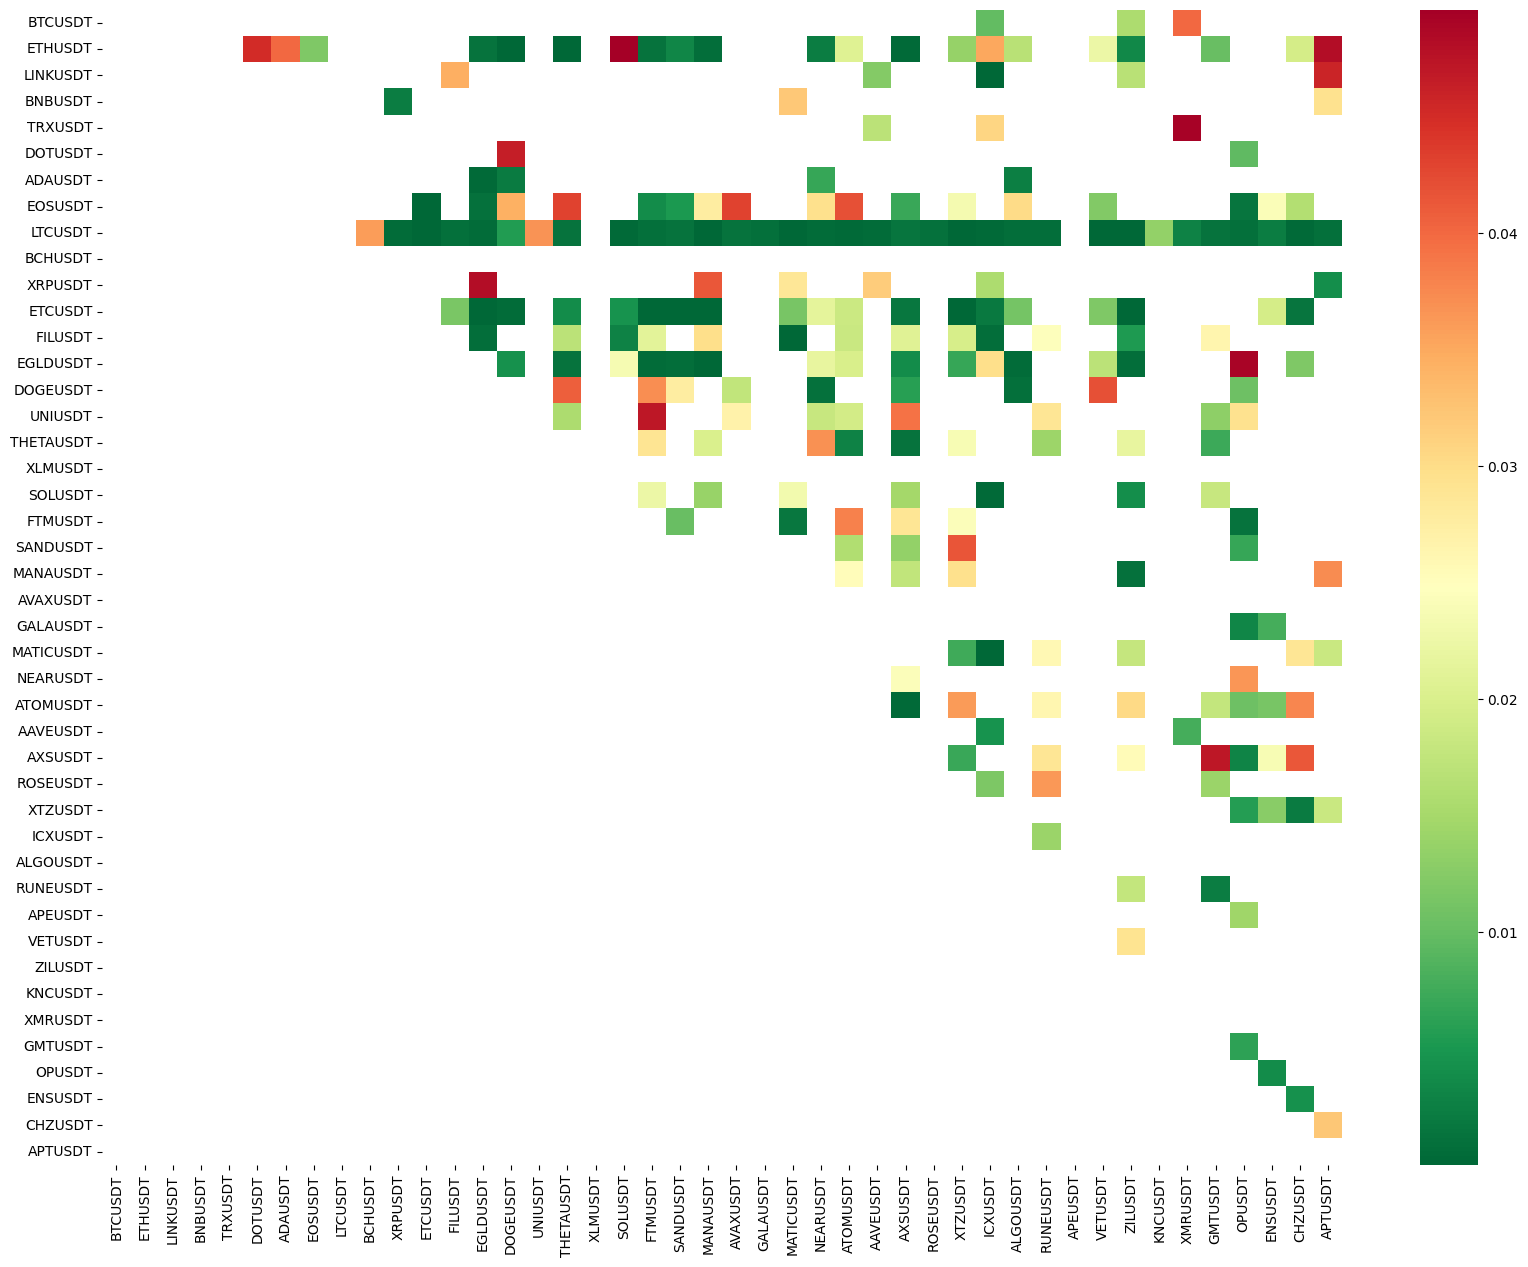

[('BTCUSDT', 'ICXUSDT'), ('BTCUSDT', 'ZILUSDT'), ('BTCUSDT', 'XMRUSDT'), ('ETHUSDT', 'DOTUSDT'), ('ETHUSDT', 'ADAUSDT'), ('ETHUSDT', 'EOSUSDT'), ('ETHUSDT', 'EGLDUSDT'), ('ETHUSDT', 'DOGEUSDT'), ('ETHUSDT', 'THETAUSDT'), ('ETHUSDT', 'SOLUSDT'), ('ETHUSDT', 'FTMUSDT'), ('ETHUSDT', 'SANDUSDT'), ('ETHUSDT', 'MANAUSDT'), ('ETHUSDT', 'NEARUSDT'), ('ETHUSDT', 'ATOMUSDT'), ('ETHUSDT', 'AXSUSDT'), ('ETHUSDT', 'XTZUSDT'), ('ETHUSDT', 'ICXUSDT'), ('ETHUSDT', 'ALGOUSDT'), ('ETHUSDT', 'VETUSDT'), ('ETHUSDT', 'ZILUSDT'), ('ETHUSDT', 'GMTUSDT'), ('ETHUSDT', 'CHZUSDT'), ('ETHUSDT', 'APTUSDT'), ('LINKUSDT', 'FILUSDT'), ('LINKUSDT', 'AAVEUSDT'), ('LINKUSDT', 'ICXUSDT'), ('LINKUSDT', 'ZILUSDT'), ('LINKUSDT', 'APTUSDT'), ('BNBUSDT', 'XRPUSDT'), ('BNBUSDT', 'MATICUSDT'), ('BNBUSDT', 'APTUSDT'), ('TRXUSDT', 'AAVEUSDT'), ('TRXUSDT', 'ICXUSDT'), ('TRXUSDT', 'XMRUSDT'), ('DOTUSDT', 'DOGEUSDT'), ('DOTUSDT', 'OPUSDT'), ('ADAUSDT', 'EGLDUSDT'), ('ADAUSDT', 'DOGEUSDT'), ('ADAUSDT', 'NEARUSDT'), ('ADAUSDT', 'ALGOU

In [9]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.columns
    cointegrated_pairs = []

    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]

            if len(S1) != len(S2):
                print(f"Mismatch for pairs: {keys[i]} and {keys[j]}")
                continue

            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                cointegrated_pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, cointegrated_pairs


# Long Term Cointegration Check
scores, pvalues, cointegrated_pairs = find_cointegrated_pairs(combined_prices_df)


# Adjust the figure size
plt.figure(figsize=(20, 15))

# Plotting the heatmap
sns.heatmap(pvalues, xticklabels=combined_prices_df.columns, yticklabels=combined_prices_df.columns, cmap='RdYlGn_r', mask=(pvalues >= 0.05))

# Display the plot
plt.show()

print(cointegrated_pairs)

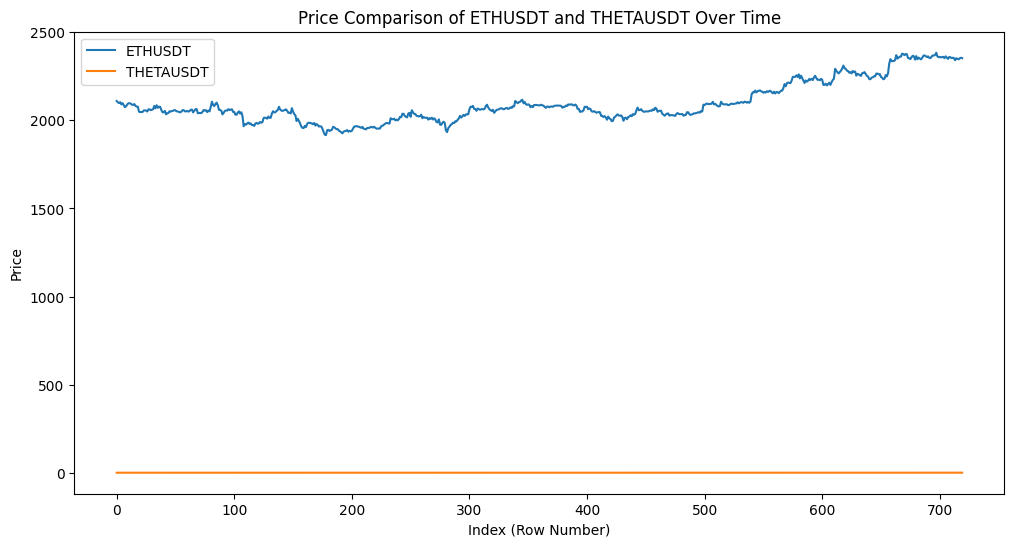

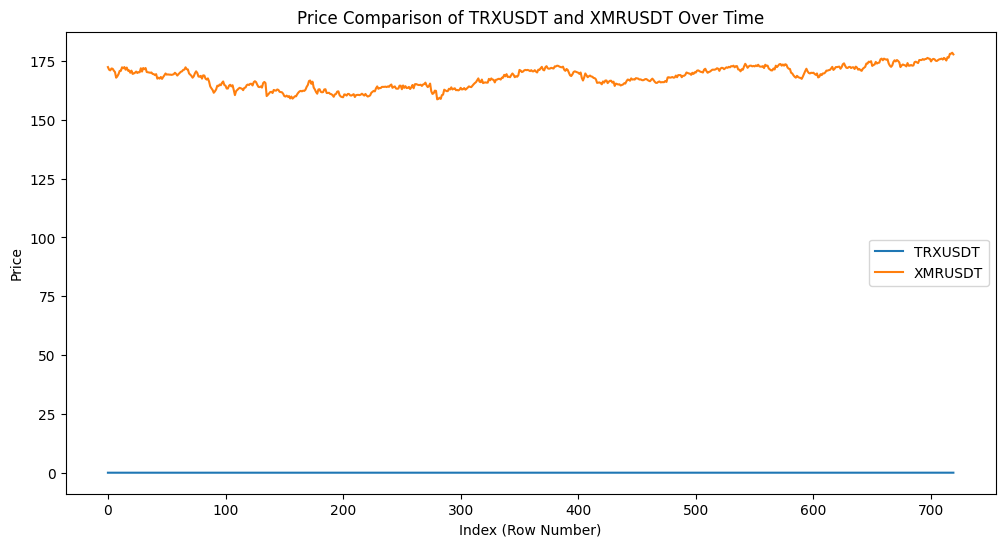

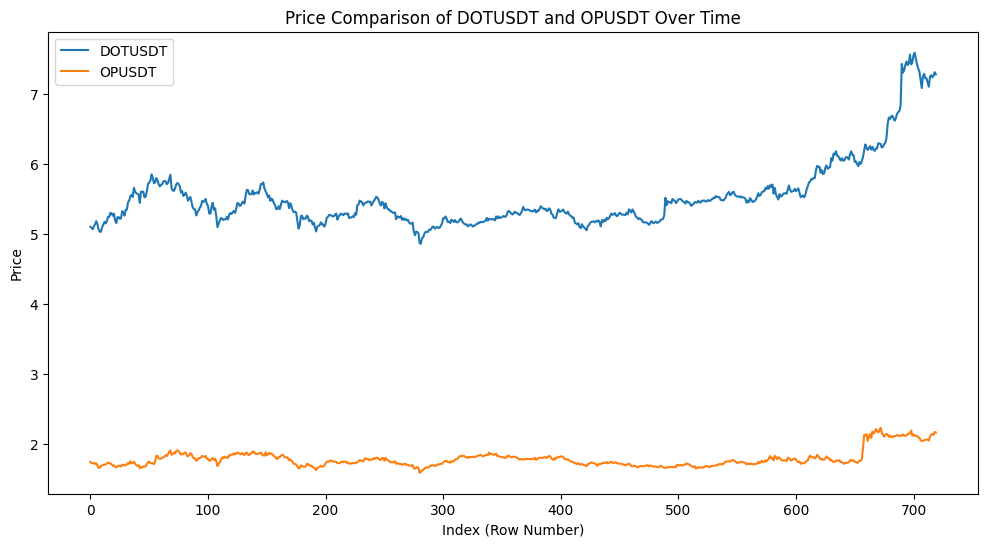

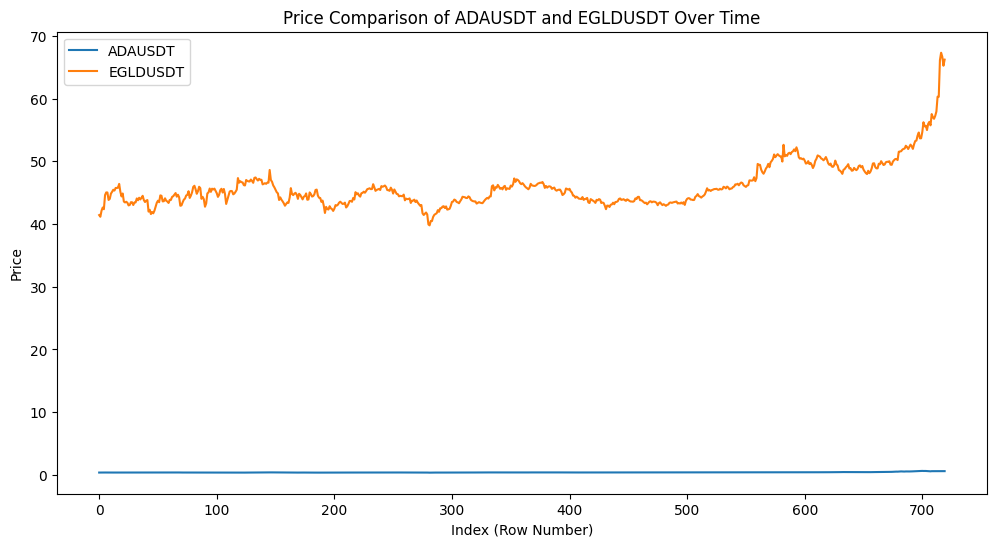

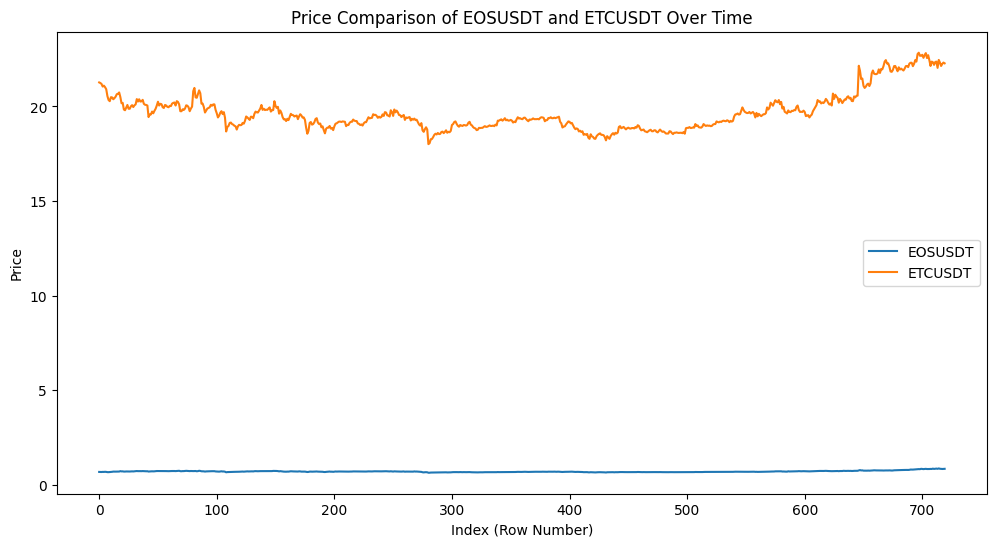

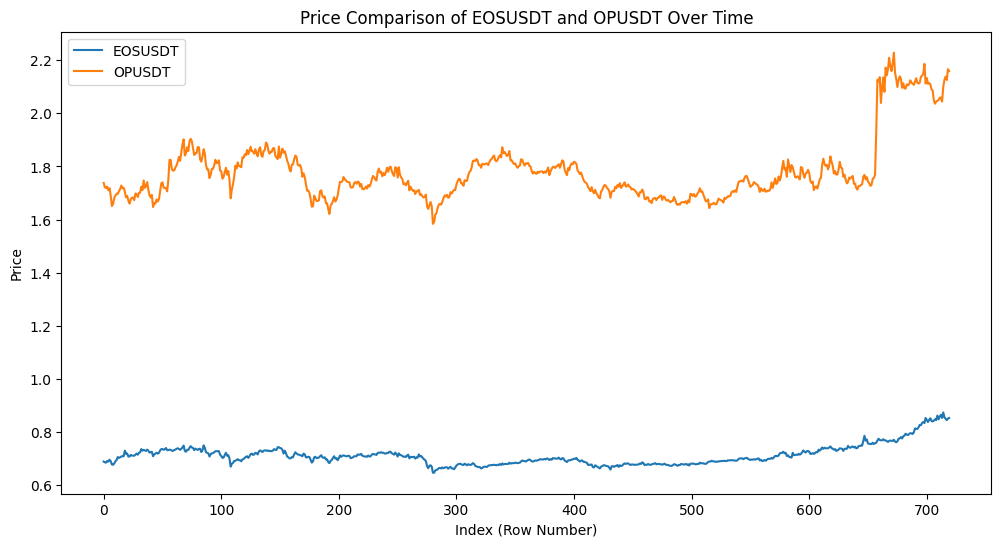

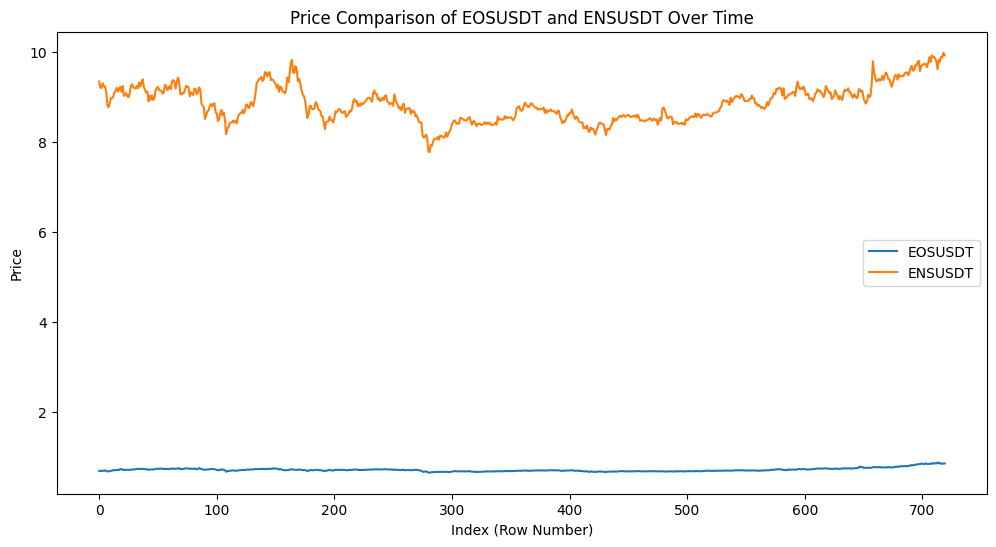

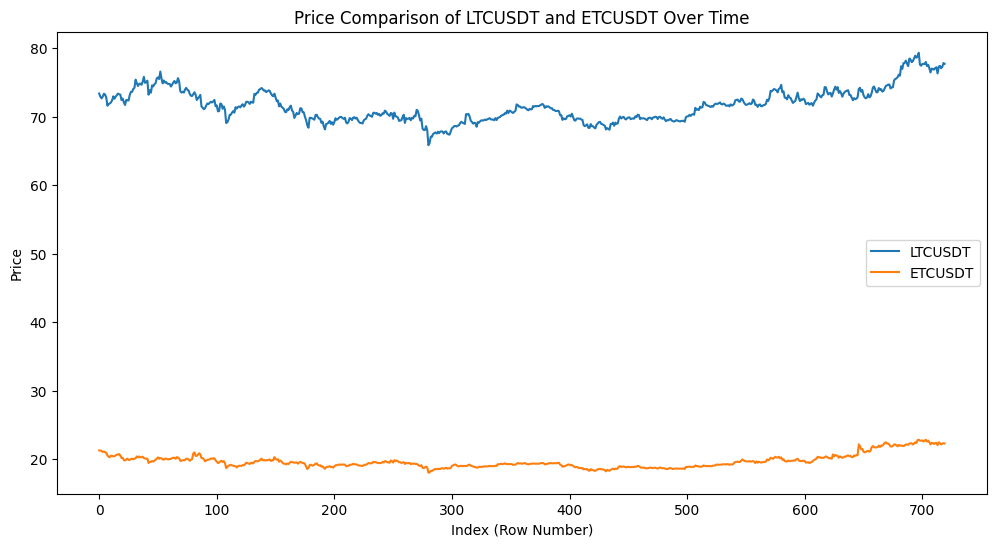

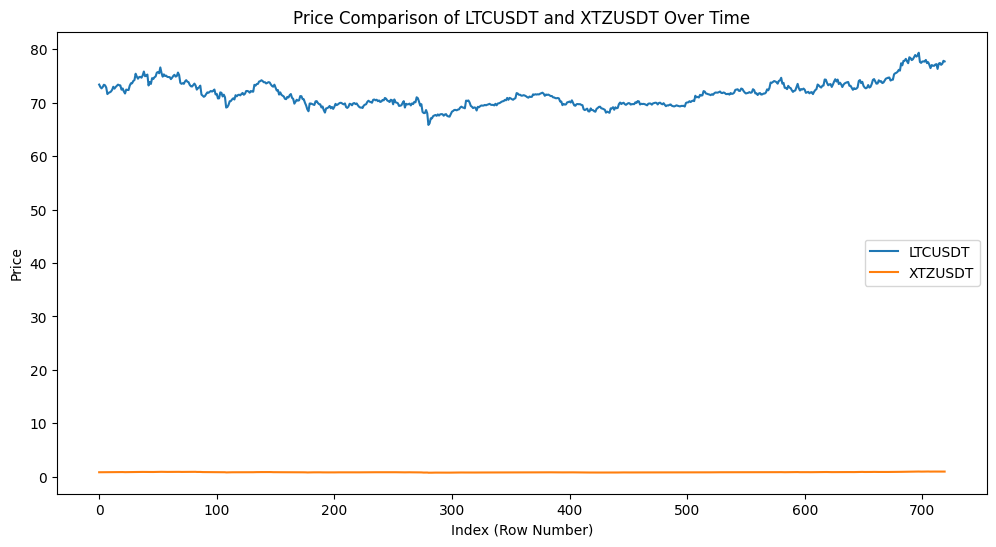

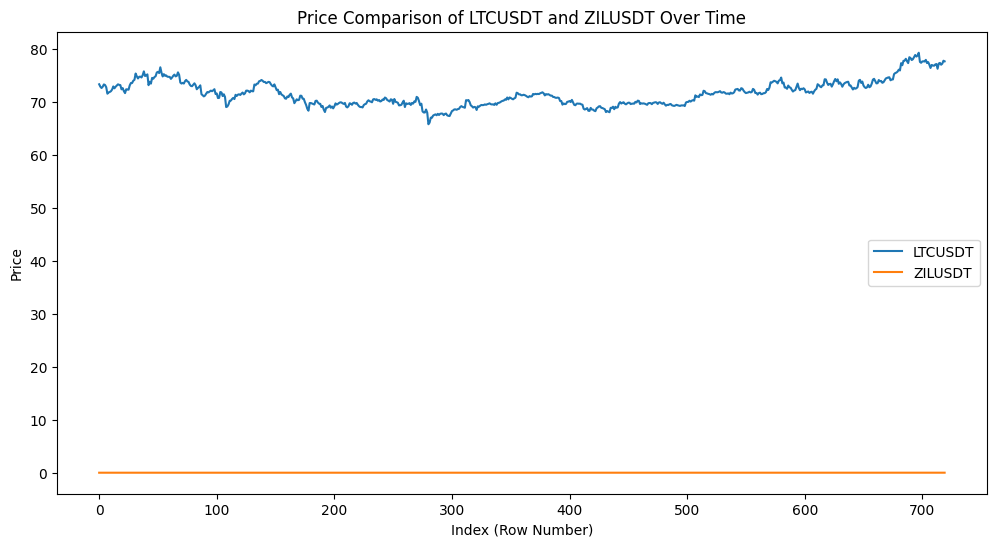

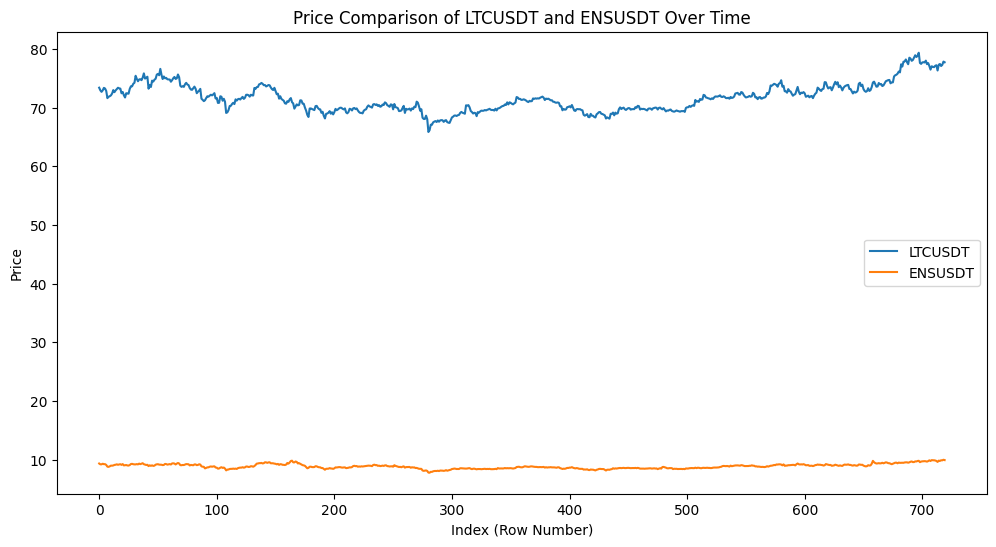

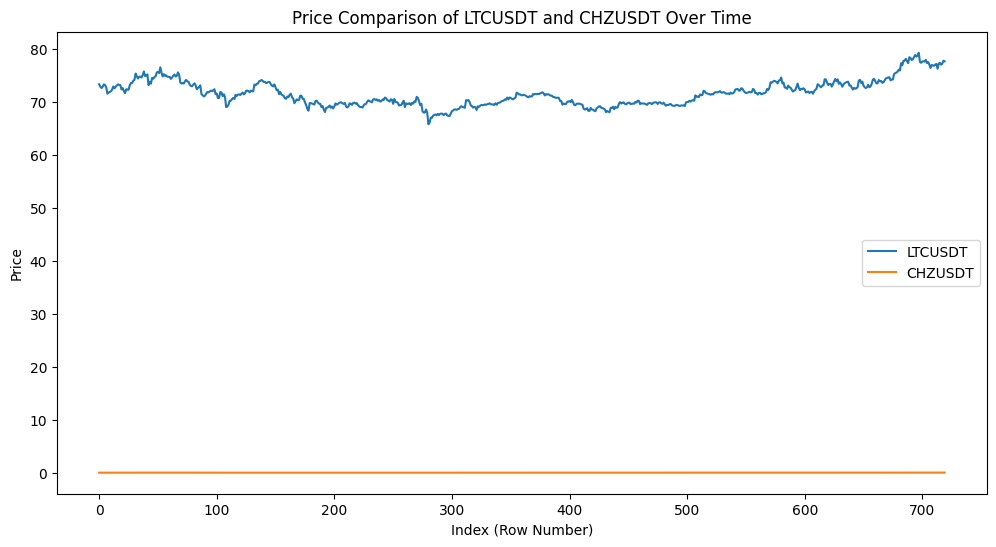

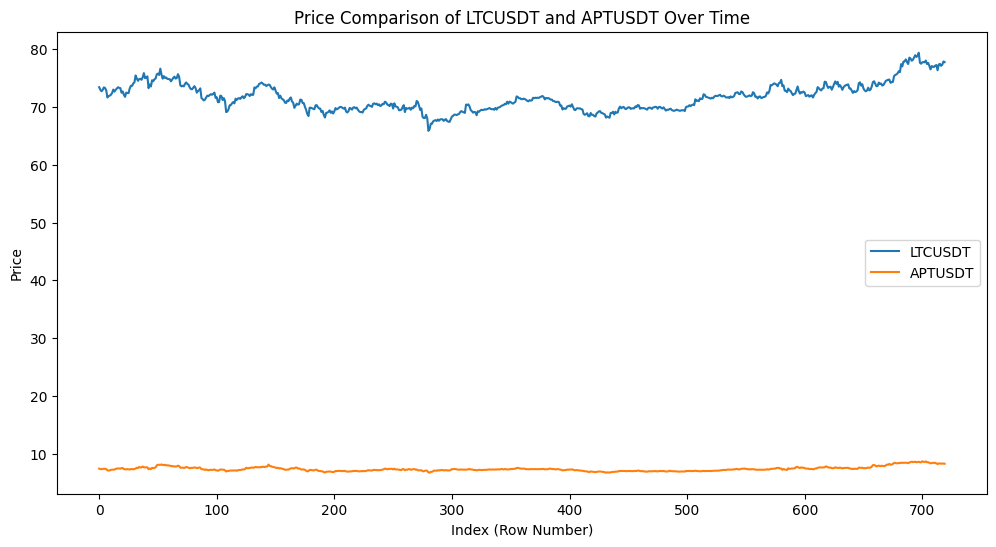

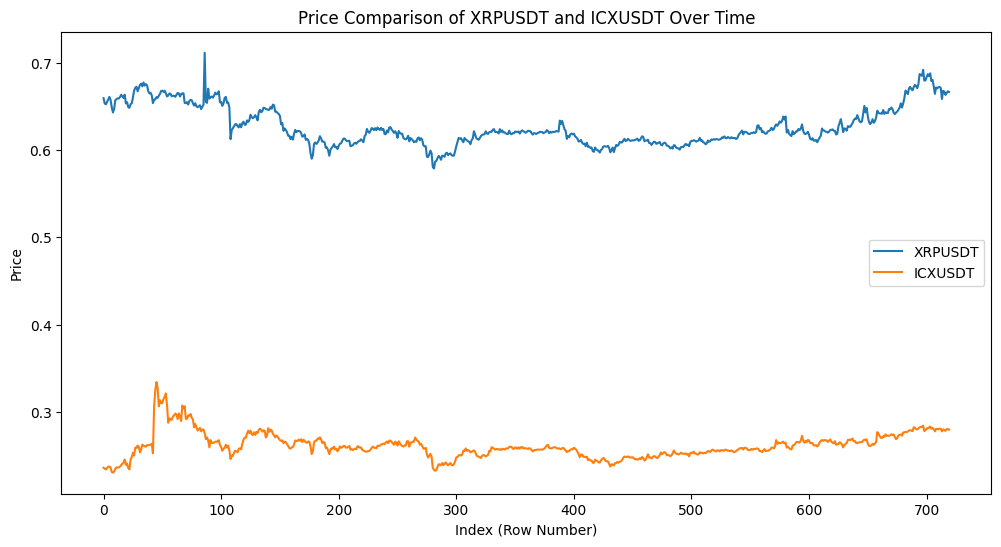

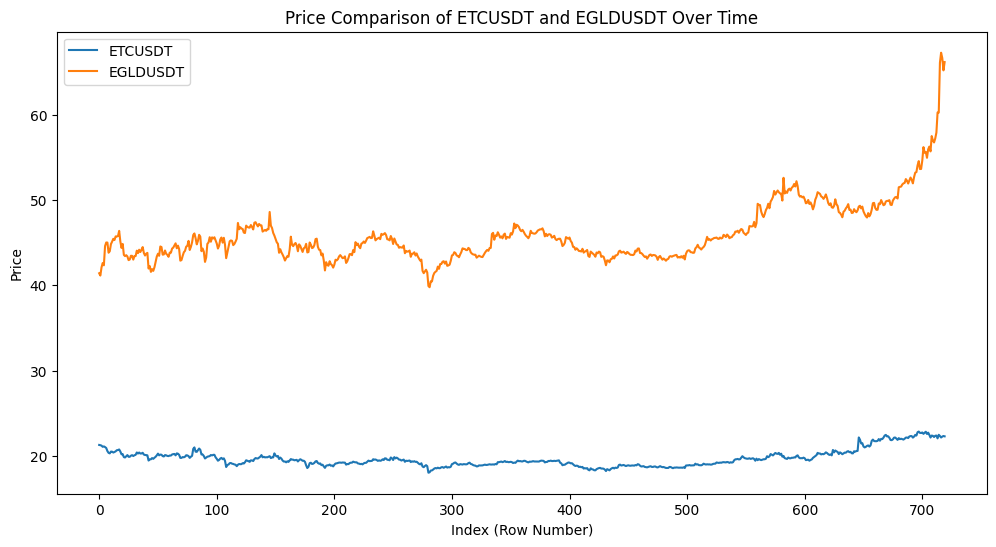

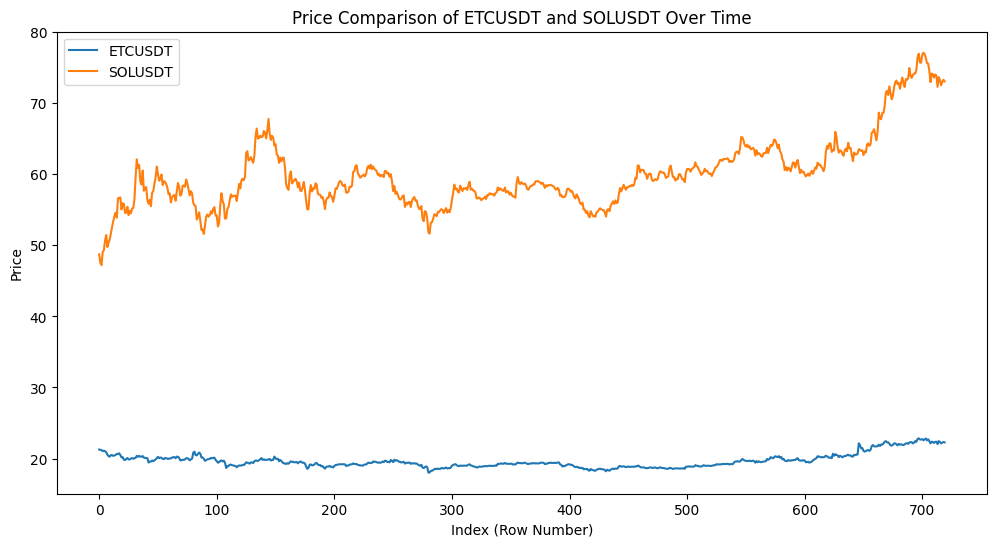

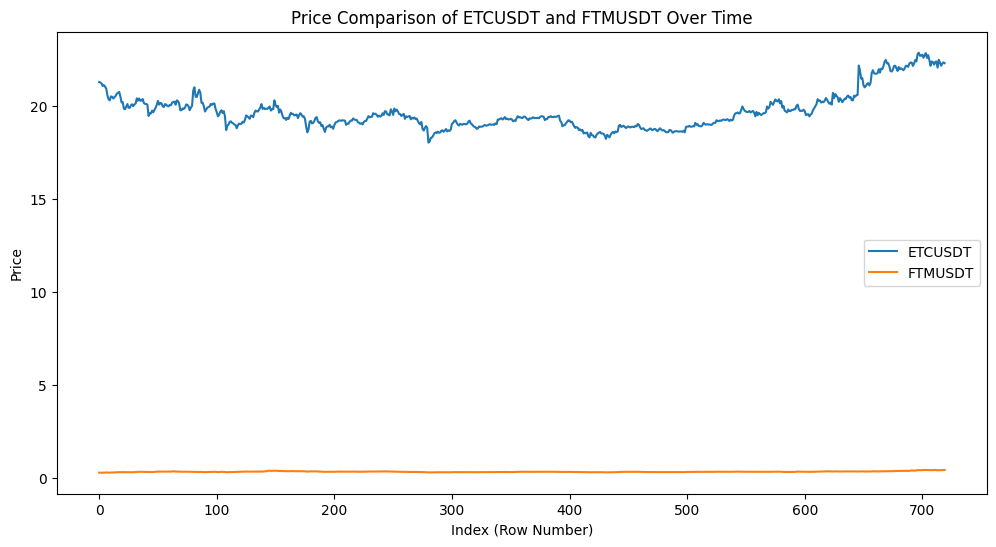

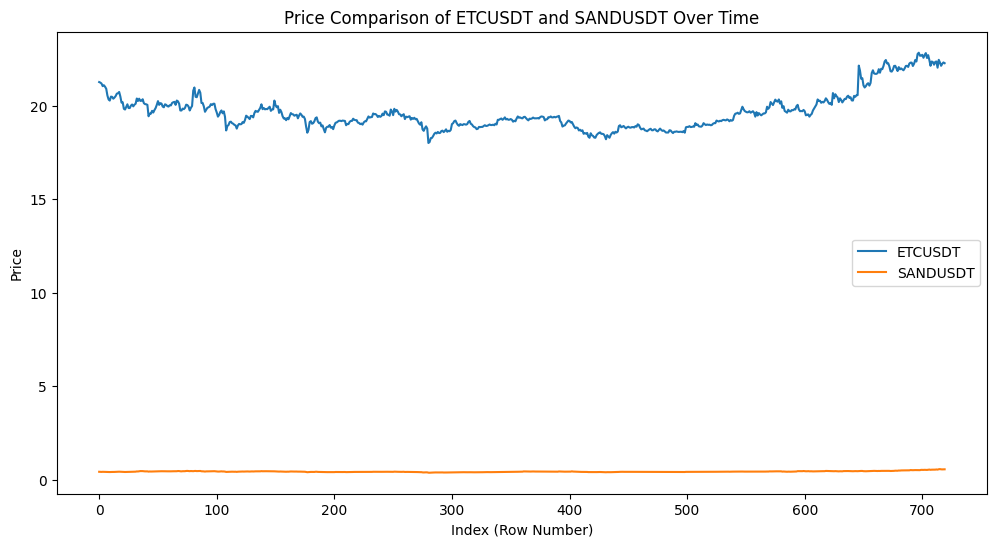

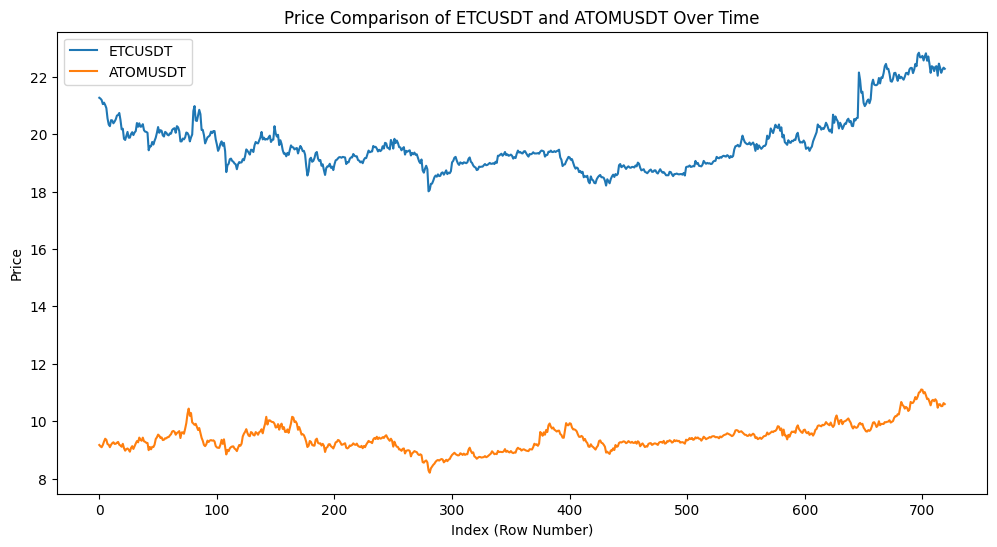

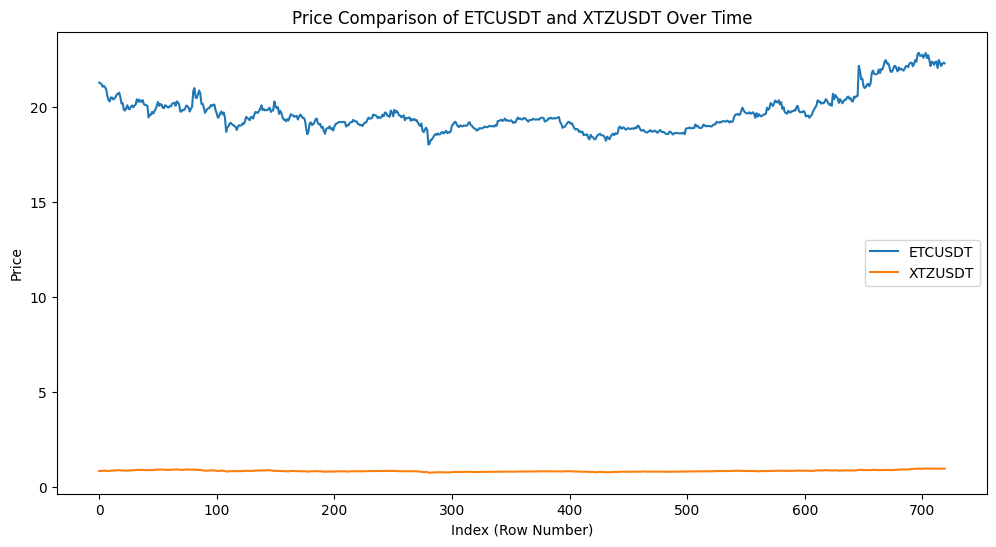

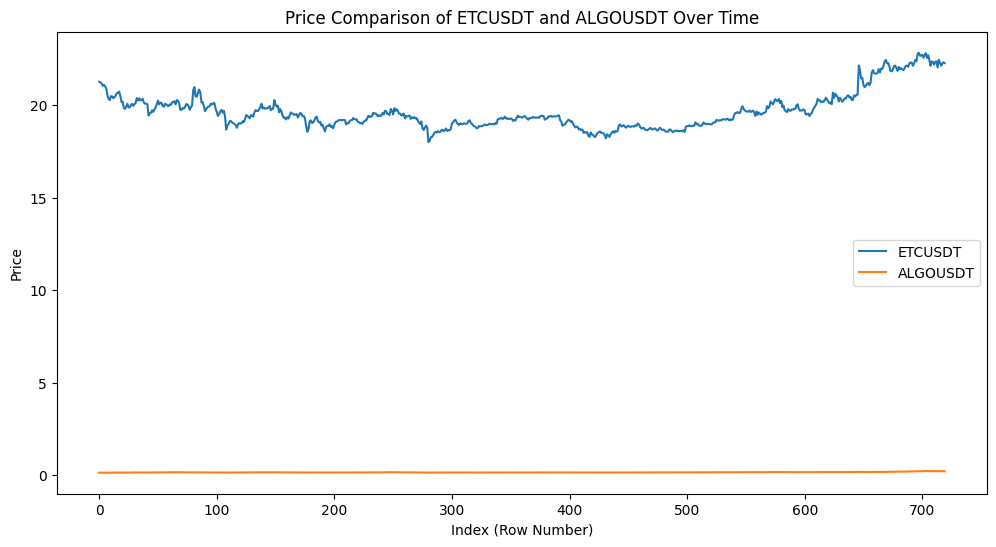

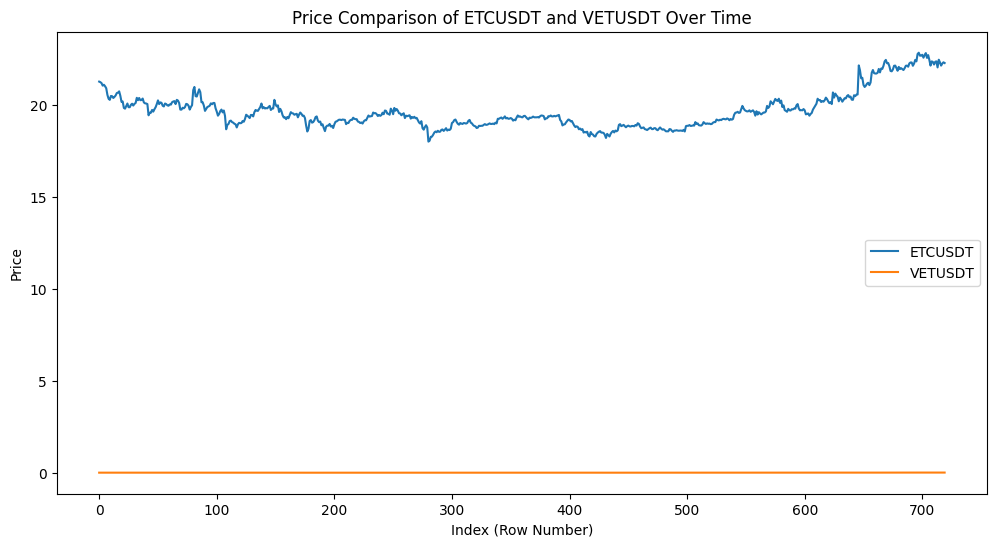

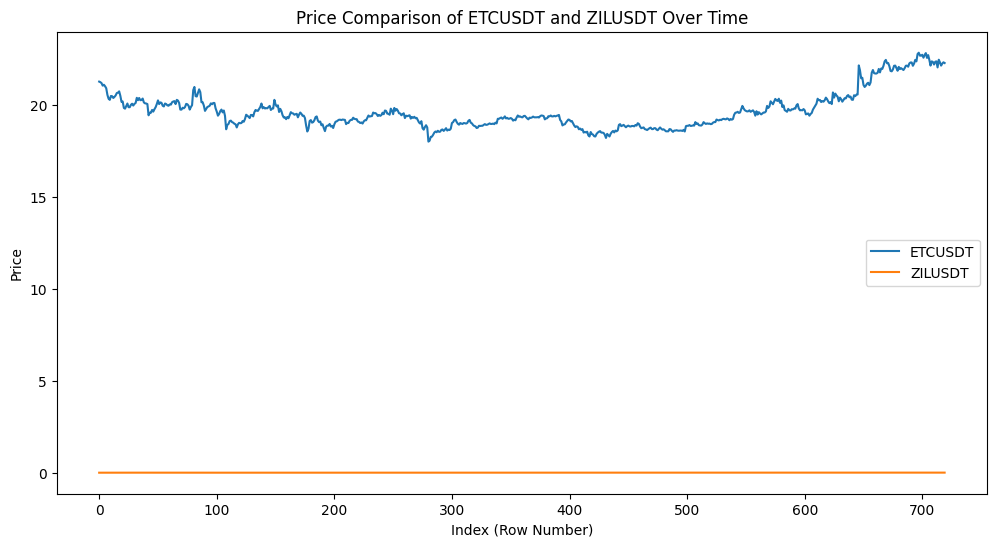

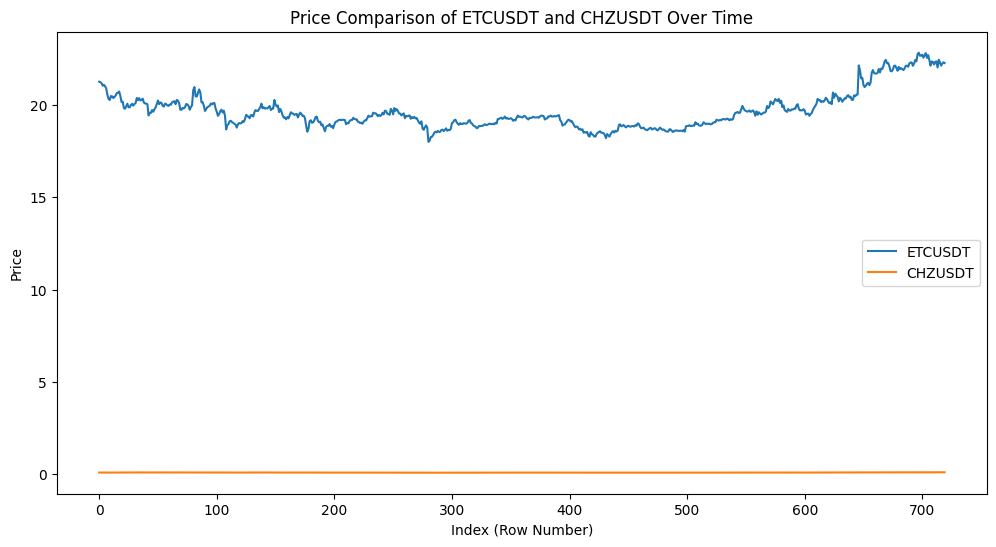

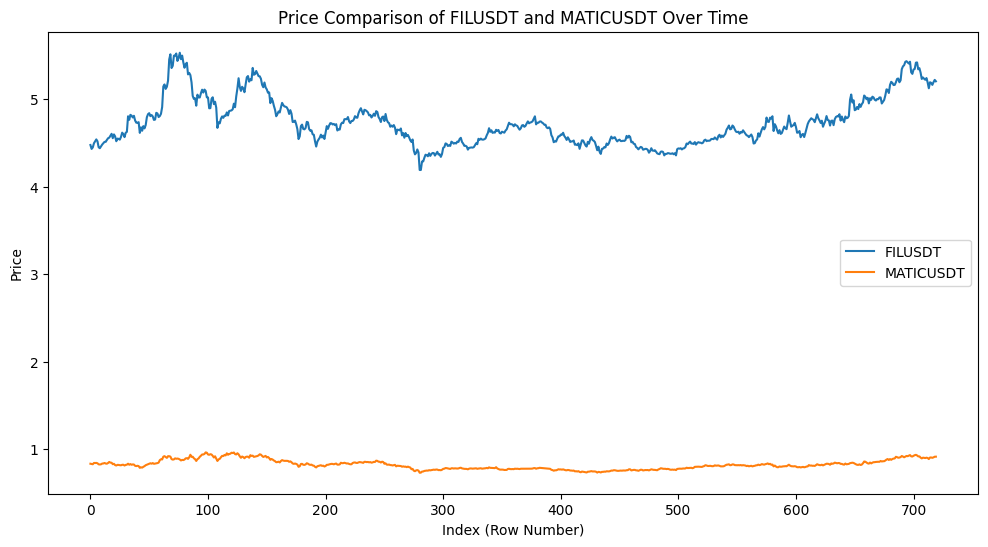

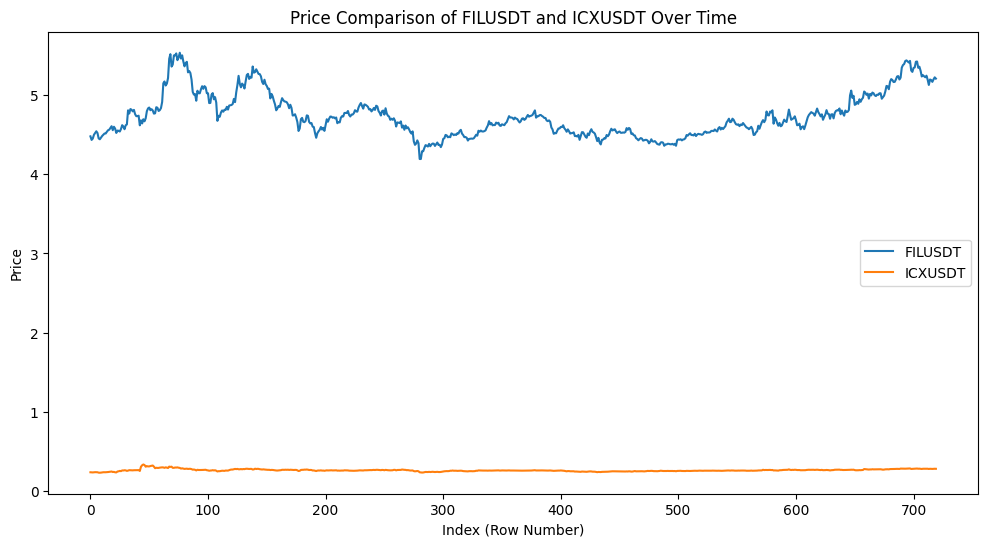

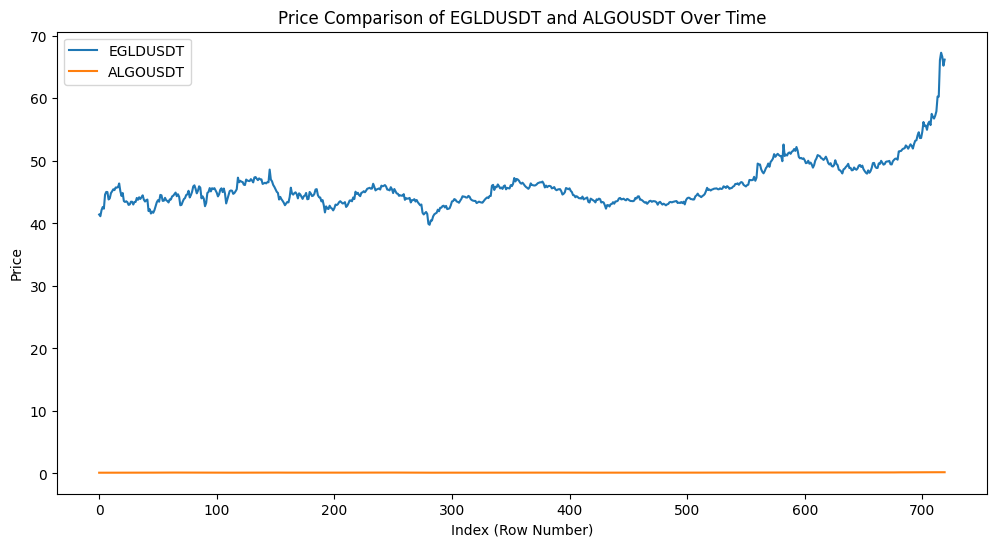

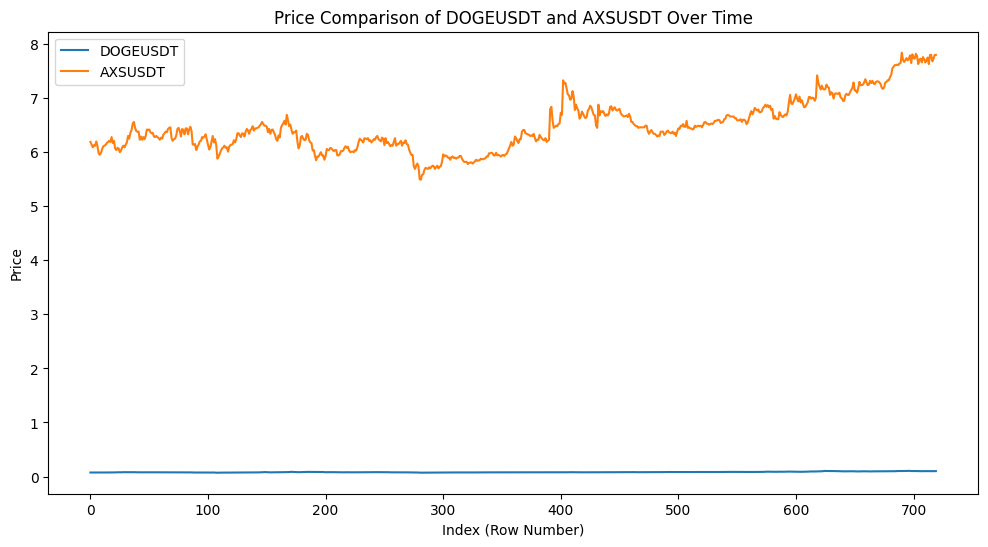

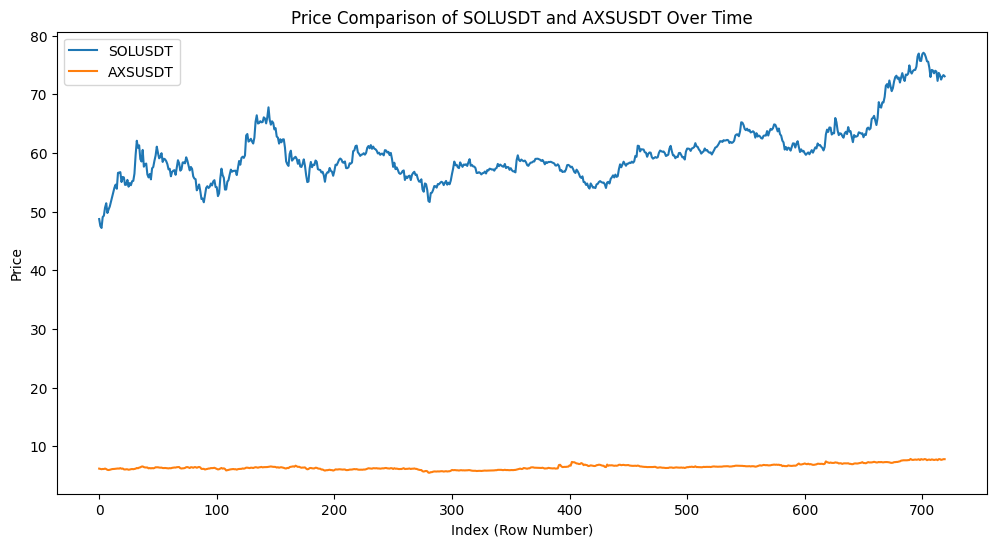

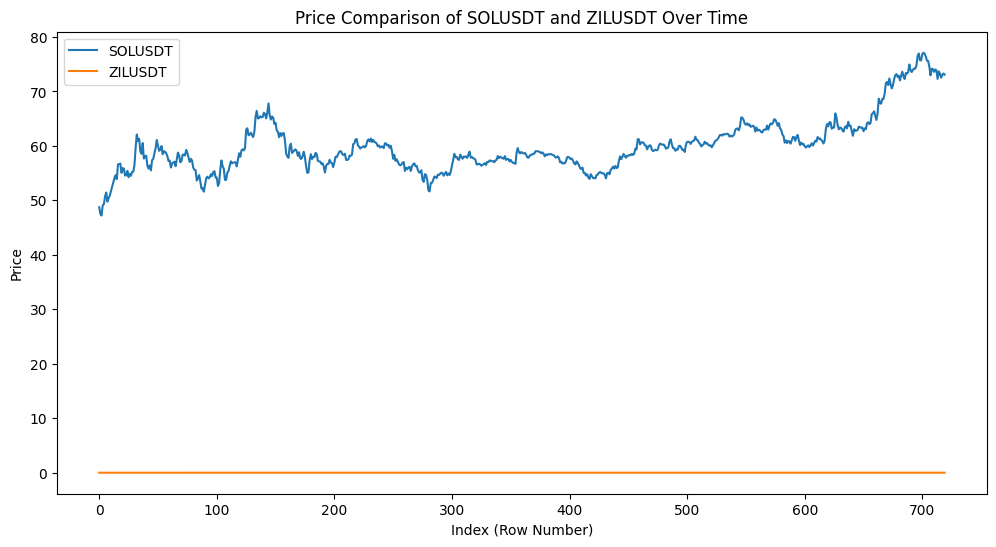

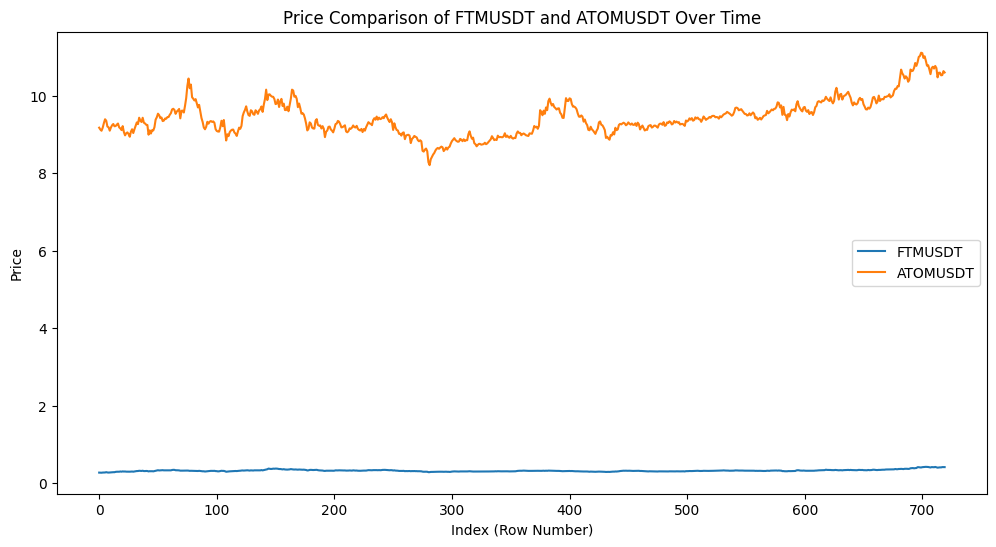

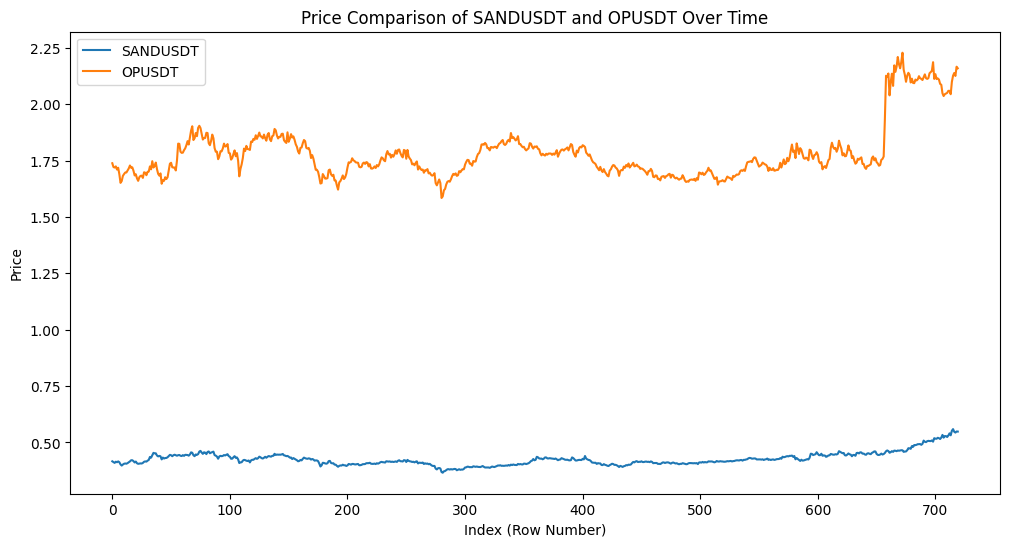

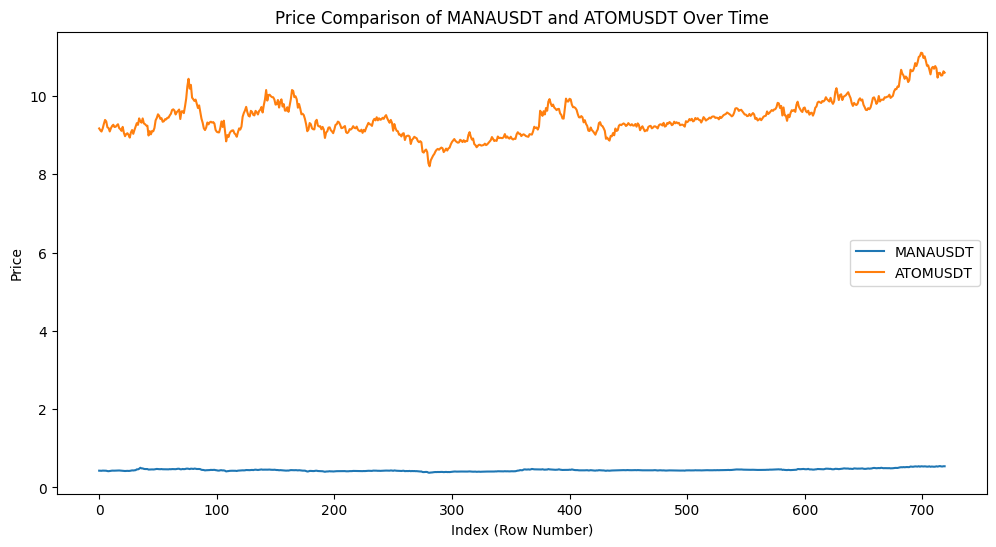

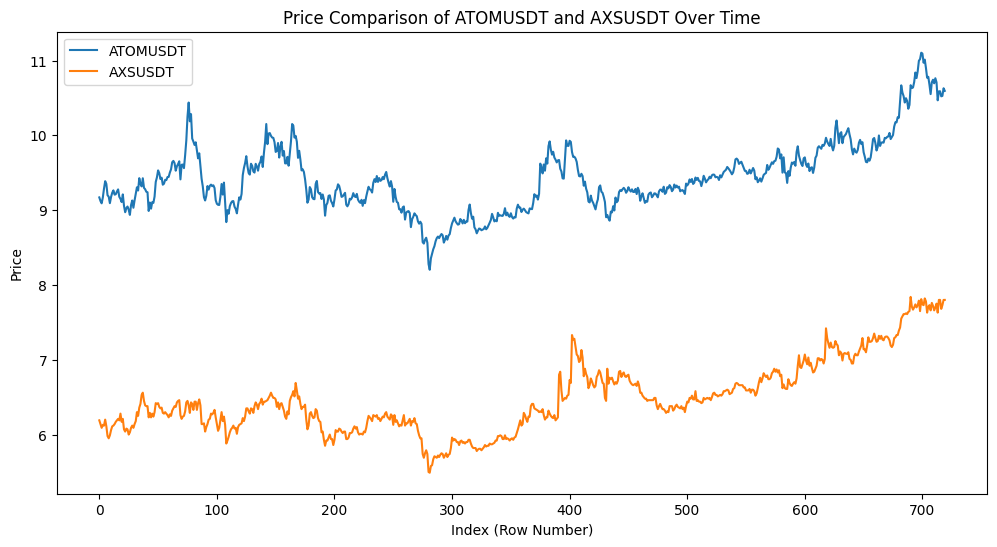

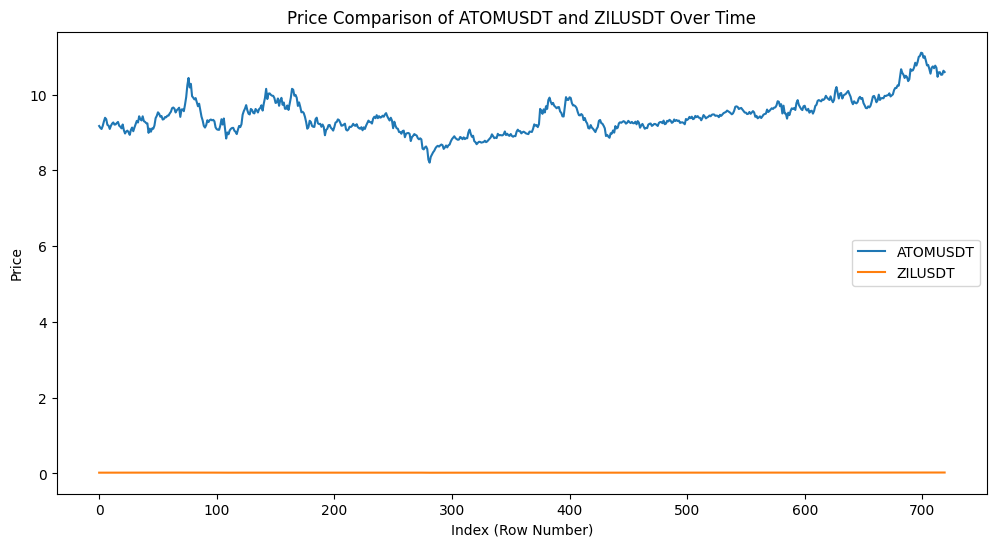

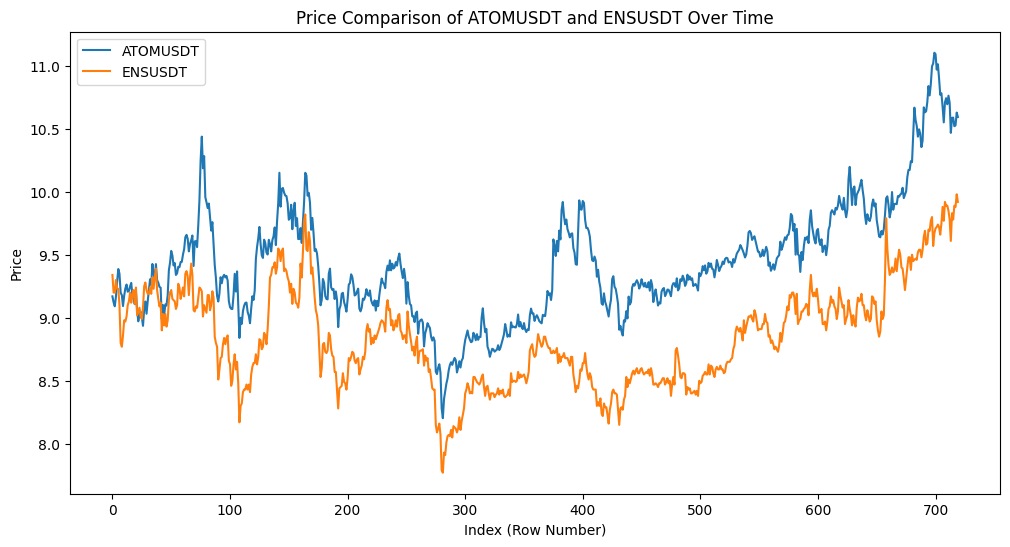

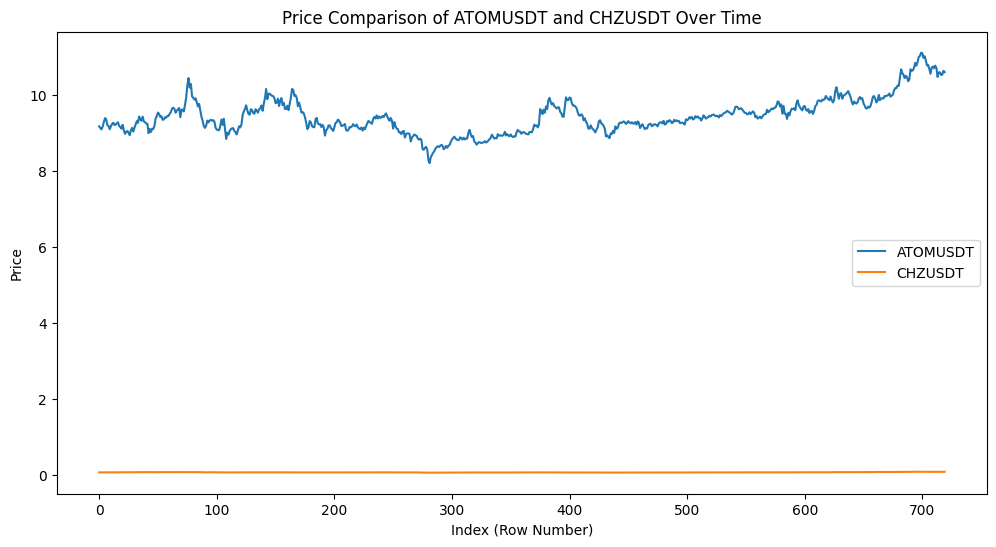

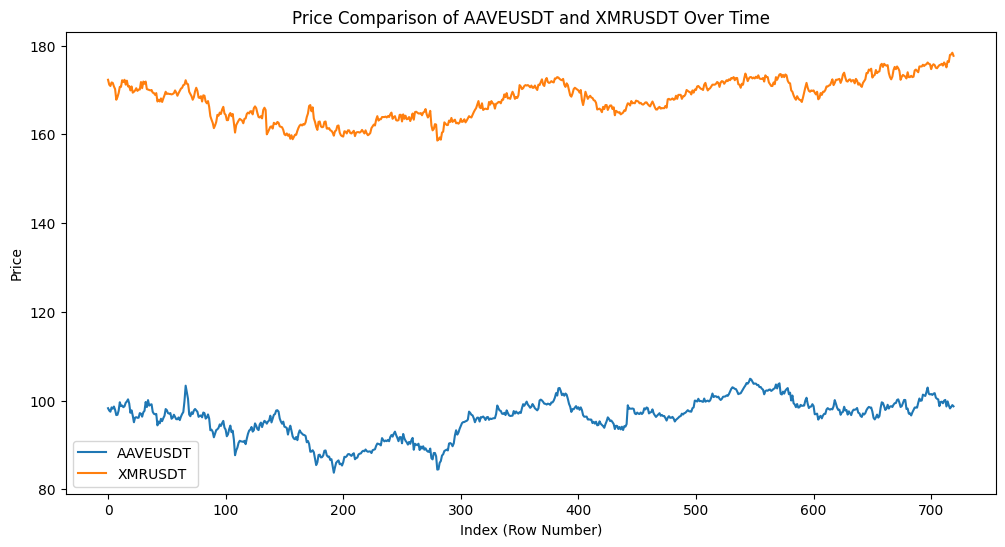

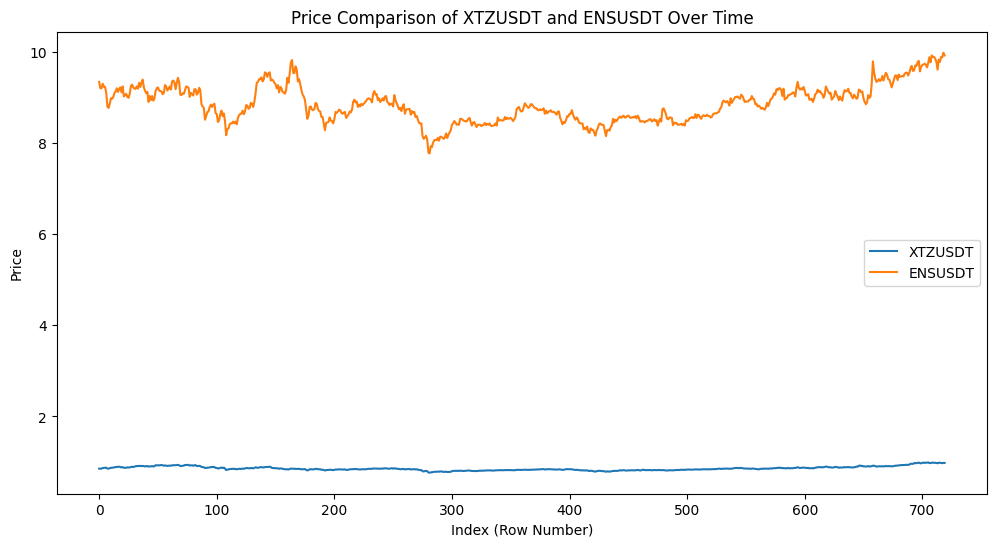

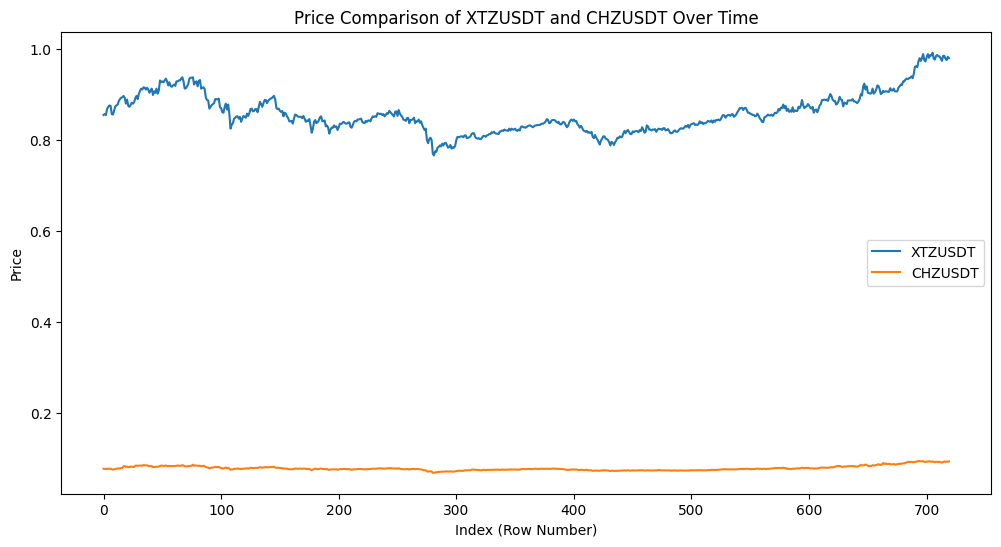

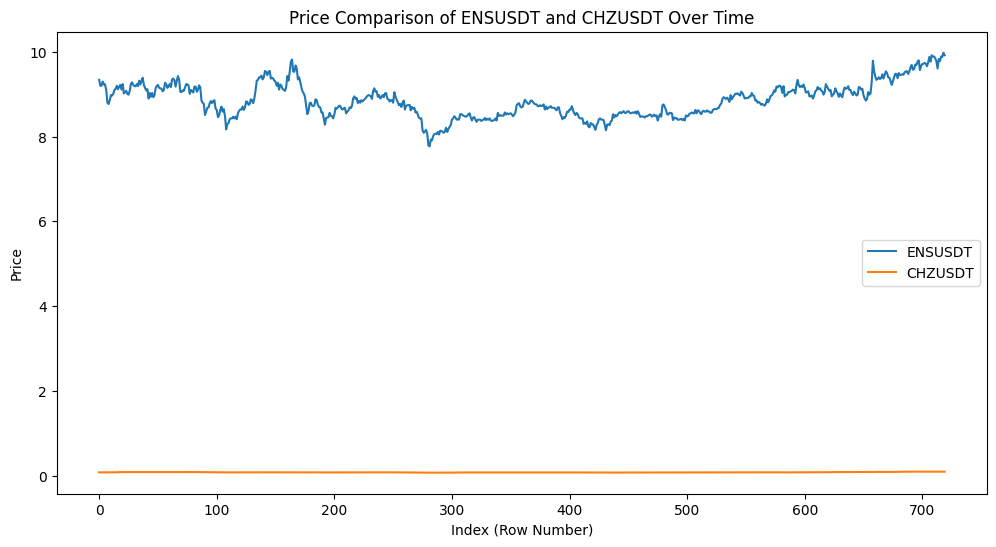

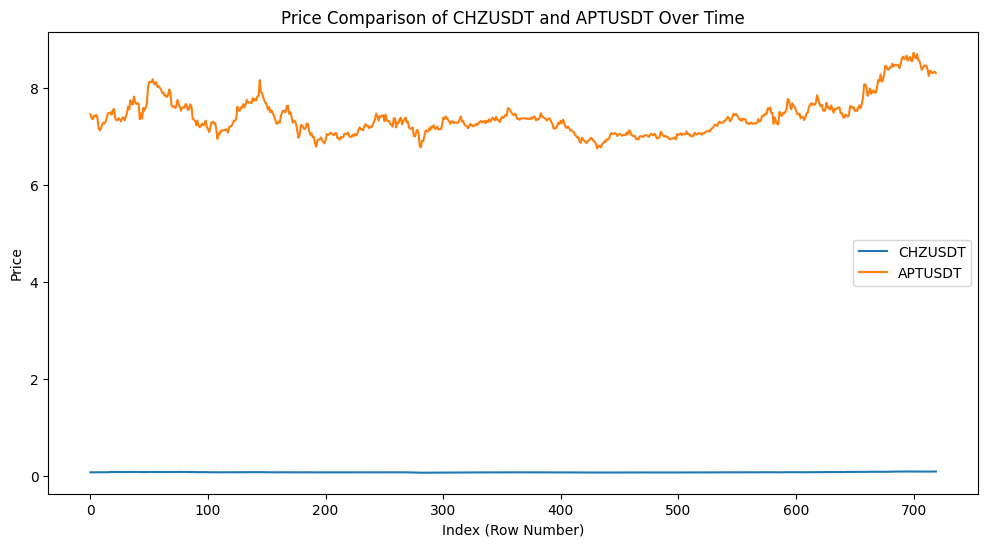

[('ETHUSDT', 'THETAUSDT'), ('TRXUSDT', 'XMRUSDT'), ('DOTUSDT', 'OPUSDT'), ('ADAUSDT', 'EGLDUSDT'), ('EOSUSDT', 'ETCUSDT'), ('EOSUSDT', 'OPUSDT'), ('EOSUSDT', 'ENSUSDT'), ('LTCUSDT', 'ETCUSDT'), ('LTCUSDT', 'XTZUSDT'), ('LTCUSDT', 'ZILUSDT'), ('LTCUSDT', 'ENSUSDT'), ('LTCUSDT', 'CHZUSDT'), ('LTCUSDT', 'APTUSDT'), ('XRPUSDT', 'ICXUSDT'), ('ETCUSDT', 'EGLDUSDT'), ('ETCUSDT', 'SOLUSDT'), ('ETCUSDT', 'FTMUSDT'), ('ETCUSDT', 'SANDUSDT'), ('ETCUSDT', 'ATOMUSDT'), ('ETCUSDT', 'XTZUSDT'), ('ETCUSDT', 'ALGOUSDT'), ('ETCUSDT', 'VETUSDT'), ('ETCUSDT', 'ZILUSDT'), ('ETCUSDT', 'CHZUSDT'), ('FILUSDT', 'MATICUSDT'), ('FILUSDT', 'ICXUSDT'), ('EGLDUSDT', 'ALGOUSDT'), ('DOGEUSDT', 'AXSUSDT'), ('SOLUSDT', 'AXSUSDT'), ('SOLUSDT', 'ZILUSDT'), ('FTMUSDT', 'ATOMUSDT'), ('SANDUSDT', 'OPUSDT'), ('MANAUSDT', 'ATOMUSDT'), ('ATOMUSDT', 'AXSUSDT'), ('ATOMUSDT', 'ZILUSDT'), ('ATOMUSDT', 'ENSUSDT'), ('ATOMUSDT', 'CHZUSDT'), ('AAVEUSDT', 'XMRUSDT'), ('XTZUSDT', 'ENSUSDT'), ('XTZUSDT', 'CHZUSDT'), ('ENSUSDT', 'CHZUSDT'

In [8]:
# Short Term more recent cointegration check
recent_number_of_bars = 720
recent_cointegration_pairs = []

for pair in cointegrated_pairs:
    prices_one = combined_prices_df[pair[0]].tail(recent_number_of_bars)
    prices_two = combined_prices_df[pair[1]].tail(recent_number_of_bars)

    if len(prices_one) != len(prices_two):
        print(f"Mismatch for pairs: {prices_one} and {prices_two}")
        continue

    result = coint(prices_one, prices_two)
    score = result[0]
    pvalue = result[1]

    if pvalue < 0.05:

        prices_one = prices_one.reset_index(drop=True)
        prices_two = prices_two.reset_index(drop=True)

        # Combine into a single DataFrame
        combined_df = pd.DataFrame({pair[0]: prices_one, pair[1]: prices_two})

        # Plotting
        plt.figure(figsize=(12, 6))
        plt.plot(combined_df[pair[0]], label=pair[0])
        plt.plot(combined_df[pair[1]], label=pair[1])

        # Adding labels and title
        plt.xlabel('Index (Row Number)')
        plt.ylabel('Price')
        plt.title(f'Price Comparison of {pair[0]} and {pair[1]} Over Time')
        plt.legend()

        # Display the plot
        plt.show()
        recent_cointegration_pairs.append((pair[0], pair[1]))

print(recent_cointegration_pairs)

In [ ]:
def rolling_hedge_ratio(self, Y, X, lookback_window):
        # Add a constant to X to represent the intercept for the OLS regression
        X_with_const = sm.add_constant(X)

        # Initialize the hedge_ratios Series to store the results
        hedge_ratios = pd.Series(index=Y.index)

        # Perform the rolling regression and calculate the hedge ratio (beta coefficient)
        rolling_model = RollingOLS(Y, X_with_const, window=lookback_window)
        rolling_results = rolling_model.fit()

        # Extract the beta coefficients (hedge ratios) from the rolling regression results
        # Use 'params' and select the second column, which represents the beta coefficient
        # The index is aligned with Y so no shifting occurs
        hedge_ratios = rolling_results.params.iloc[:, 1]

        return hedge_ratios


for pair in recent_cointegration_pairs:

    prices_one = combined_prices_df[pair[0]].tail(recent_number_of_bars)
    prices_two = combined_prices_df[pair[1]].tail(recent_number_of_bars)

    if len(prices_one) != len(prices_two):
        print(f"Mismatch for pairs: {prices_one} and {prices_two}")
        continue

    result = coint(prices_one, prices_two)
    score = result[0]
    pvalue = result[1]

    if pvalue < 0.05:

        prices_one = prices_one.reset_index(drop=True)
        prices_two = prices_two.reset_index(drop=True)

        # Combine into a single DataFrame
        combined_df = pd.DataFrame({pair[0]: prices_one, pair[1]: prices_two})

        # Plotting
        plt.figure(figsize=(12, 6))
        plt.plot(combined_df[pair[0]], label=pair[0])
        plt.plot(combined_df[pair[1]], label=pair[1])

        # Adding labels and title
        plt.xlabel('Index (Row Number)')
        plt.ylabel('Price')
        plt.title(f'Price Comparison of {pair[0]} and {pair[1]} Over Time')
        plt.legend()

        # Display the plot
        plt.show()
        recent_cointegration_pairs.append((pair[0], pair[1]))

print(recent_cointegration_pairs)